In [3]:
import requests
from bs4 import BeautifulSoup
import pandas
import numpy as np
import re
from datetime import date, timedelta

In [16]:
nbr_of_pages = "10" #TODO - fetch the number of pages from the website
url_path = "https://www.monster.se/jobb/l-göteborg,-västra-götaland.aspx?stpage=1&page=" + nbr_of_pages

In [5]:
def get_soup(url_path):
    r = requests.get(url_path)
    c = r.content
    return BeautifulSoup(c, "html.parser")

In [6]:
def get_date(item, today):
    tmp = item.find("div", {"class":"meta flex-col"})
    posted_date = get_posted_date(tmp, today) if tmp is not None else (None, None)
    return posted_date

In [7]:
def get_posted_date(tmp, today):
    text = tmp.find("time").text
    match = re.search("idag", text)
    posted_days_ago = 0
    
    if not match:
        posted_days_ago = int(re.sub("\D", "", text))
    return (today - timedelta(days = posted_days_ago), text)

In [8]:
def get_page_information(path):
    ss = get_soup(path)
    job_details = ss.find("div", {"class":re.compile("^job-details container")})

    detailed_info = {}
    for i in job_details.find_all("div", {"class", "detail-row row"}):
        t = i.find_all("div")
        #I have recevied the job type (for the same url) in english, swedish and italian(?), so check for both swedish and english
        if t[0].text == "Job Type" or t[0].text == "Jobbtyp" or t[0].text == "Tipo di contratto":
            detailed_info["Job Type"] = translate_job_type(t[1].text)
        #TODO - fetch other values?
    return detailed_info

In [9]:
def translate_job_type(job_type):   
    if job_type == None:
        return None
    if re.search('time', job_type, re.IGNORECASE):    #The job type is written in english
        return job_type.title()
    # Try to translate the job type to english, leave it as it is if its not part of the dictonary below
    rep = {"Heltid":"Fulltime", "Tillsvidare":"Employee", "Halvtid":"Parttime", "Tempo Pieno": "Fulltime"}
    
    pattern = re.compile("|".join(map(re.escape, rep)))
    
    def translate(match):
        return rep[match.group(0)]
    return pattern.sub(translate, job_type)

In [17]:
soup = get_soup(url_path)  
all_jobs = soup.find_all("section", {"class":"card-content"})
job_list = []
count = -1

today = date.today()

for item in all_jobs:
    count += 1
    if count == 0:  #Skip the first as it's an info box
        continue
    
    job_item = {}
    
    try:
        # Some sections does not hold a job, ignore those
        job_item["Company"] = item.find("a", {"class":"name"}).text.replace("\n", "").replace("\r", "")
        
    except:
        continue
    
    title_element = item.find("h2", {"class":"title"})
    
    job_item["Title"] = title_element.text.replace("\n", "").replace("\r", "")
    
    #job_item["Title"] = item.find("h2", {"class":"title"}).text.replace("\n", "").replace("\r", "")
    job_item["Location"] = item.find("span", {"class":"name"}).text.replace("\n", "").replace("\r", "")
    
    posted_date = get_date(item, today)
    job_item["Posted date"] = posted_date[0]
    job_item["Days since posted"] = posted_date[1]
    
    page_url = title_element.find("a", href=True)['href']
    job_item["Page URL"] = page_url

    #Fetch information from each individual job page    
    detailed_info = get_page_information(page_url)
    job_item["Job Type"] = detailed_info.get("Job Type") #else None
    #job_item["Line of business"]= detailed_info.get("Branscher")
    
    
    job_list.append(job_item)
df = pandas.DataFrame(job_list)

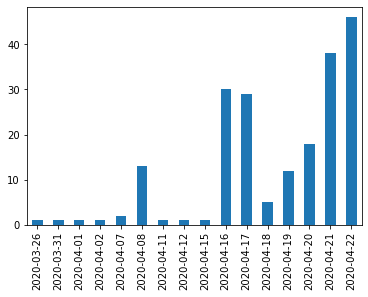

In [18]:
posted_jobs_per_day = df["Posted date"].value_counts().sort_index()
posted_jobs_per_day.plot(kind='bar')

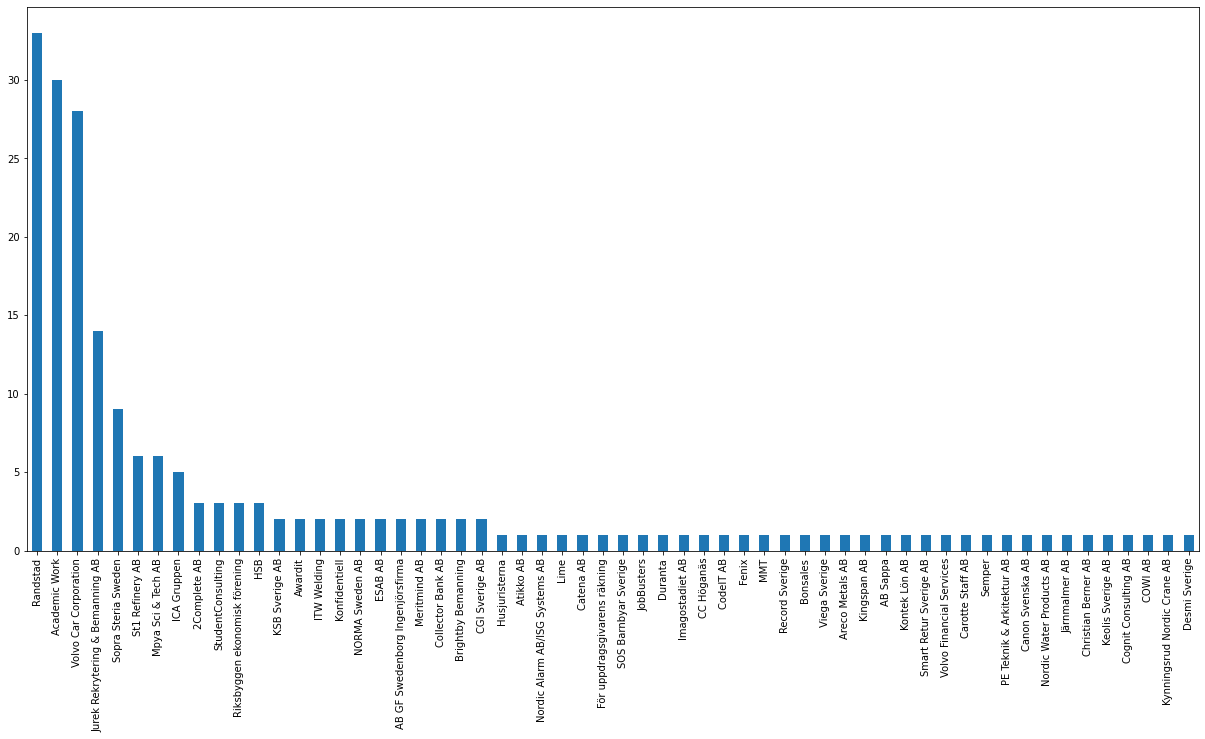

In [19]:
posted_per_company = df["Company"].value_counts()
posted_per_company.plot(kind="bar", figsize=(int((len(posted_per_company)/3)+2), 10))